# Fourier Transform + Data Representation in Fourier Space

Sources/More Reading:
- Oliver Hahn's lecture 'Data Science for Astronomy'
- 

The Fourier basis is a convenient basis in many cases, it decomposes a singal to its Fourier series. For the *n*-dimensional case the Fourier basis is given by two sets of vectors:
$$
c_j = [1, cos(2\pi 1/n), cos(2\pi 2/n), ..., cos(2\pi (n-1)/n)]^T
$$
with *j* = 0, ..., *n*/2-1
$$
s_j = [0, sin(2\pi 1/n), sin(2\pi 2/n), ..., sin(2\pi (n-1)/n)]^T
$$
with *j* = 1, ..., *n*/2

In the Discrete Fourier Transform (DFT) the two are combined to a single complex vector $\hat f_j = c_j - i s_j$ with the basis matrix representation $F_{kl} = \text{exp}[-i2\pi kl/n]$. In contrast to the cartesian basis, different pixels are correlated. The fourier basis is especially useful for **dimensionality reduction** ( = the projection of a data set onto a subspace of the full vector space, if the sub-space is determined by a smaller basis, the dimensionality of the data set in the subspace is trivially reduced, aka one discards te coefficients associated with the omitted basis vectors) or **data compression**. In the Cartesian space for an image that would correspond to pixels being discarded. In the fourier basis, if we for example retain only the coefficients corresponding to the low frequencies, we can obtain a compressed represenation of the image. 


In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

filepath = '../data/DECals_galaxies.hdf5'

with h5py.File(filepath, "r") as F:
    data = np.array(F["images_spirals"])

#### Data Compression

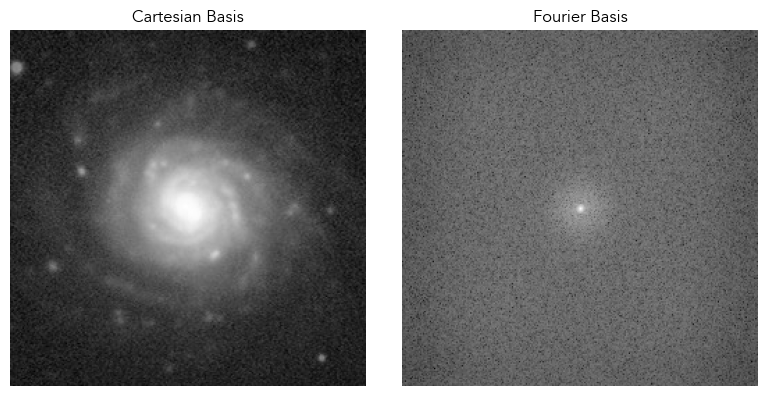

 
In the Fourier Basis, the constant mode is located in the very centre of the image. Nothing has been lost of gained, the information 
      in the two images is the same. The Fourier Basis is a different way of representing the same information. Now let us filter for the low frequency components.
      Since the lowest frequency components are located in the centre of the image, we can filter for the low frequency components by creating a mask that
      selects the pixels in the centre of the image. We then set all other pixels to zero. We then inverse transform the filtered image back to the Cartesian space.
      In the fourier space, the outer pixels are lost, those pixesl are dominated by noise. In the cartesian space, we can still clearly see the spiral pattern, despite just using 
        5% of the coefficients!



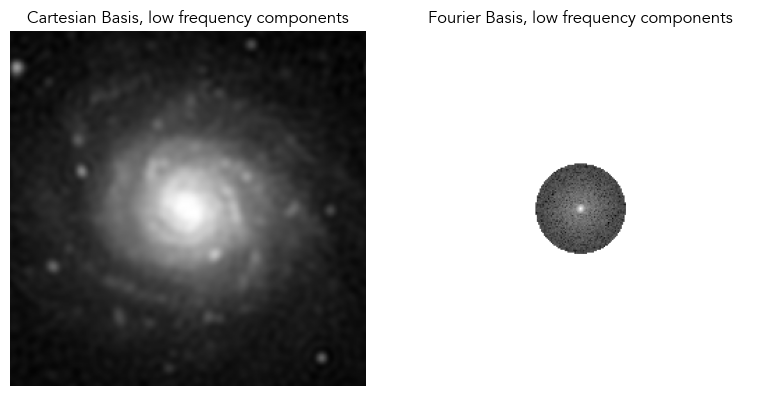

In [3]:
galaxy = data[190, ...].mean(axis=2)
fgalaxy = np.fft.fft2(galaxy)
fgalaxy_shifted = np.fft.fftshift(fgalaxy) # shift the zero frequency to the centre

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi = 100)

ax[0].imshow(galaxy, cmap='gray')
ax[1].imshow(np.abs(fgalaxy_shifted), cmap='gray', norm = 'log') # fftshift to center the zero frequency, rather than the top left corner

ax[0].set_title('Cartesian Basis')
ax[1].set_title('Fourier Basis')
for ax in ax:
    ax.axis('off')
plt.show()

print(""" 
In the Fourier Basis, the constant mode is located in the very centre of the image. Nothing has been lost of gained, the information 
      in the two images is the same. The Fourier Basis is a different way of representing the same information. Now let us filter for the low frequency components.
      Since the lowest frequency components are located in the centre of the image, we can filter for the low frequency components by creating a mask that
      selects the pixels in the centre of the image. We then set all other pixels to zero. We then inverse transform the filtered image back to the Cartesian space.
      In the fourier space, the outer pixels are lost, those pixesl are dominated by noise. In the cartesian space, we can still clearly see the spiral pattern, despite just using 
        5% of the coefficients!
""")

# Filtering for the low frequency components: we create a mask
rows, cols = galaxy.shape
centre_row, centre_col = rows//2 , cols//2

radius = np.sqrt(0.05 * rows *cols /np.pi) # we compute radius that contains 5% of the total pixels
y, x = np.ogrid[-centre_row:rows-centre_row, -centre_col:cols-centre_col]
mask = np.sqrt(x**2 + y**2) <= radius

fgalaxy_filtered = fgalaxy_shifted.copy()
fgalaxy_filtered[~mask] = 0

galaxy_filtered = np.fft.ifft2(fgalaxy_filtered)  # inverse to cartesian space, this is the downscaled image

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi = 100)

ax[0].imshow(abs(galaxy_filtered), cmap='gray')
ax[0].set_title('Cartesian Basis, low frequency components')
ax[1].imshow(abs(fgalaxy_filtered), cmap='gray', norm = 'log')
ax[1].set_title('Fourier Basis, low frequency components')
for ax in ax:
    ax.axis('off')
plt.show()


The Discrete Wavelet transform: One shortcoming of the Fourier basis is that it is not localised, the cartesian basis for example is localised, (meaning that it did not include any non-local information). We can bridge these two concepts using wavelets, localised wave packages. They have the nice perk that they come in pairs, as scaling functions and wavelets, which can split a signal into two sets of coefficients, 'coarse information' aka the bigger picture and the details, the fine information.

Any operation we do on the one representation, there is an equivalent operation that can be done on the other. Almost always one of them is easier to compute or favorable for different reasons. When we convolve two images in the spatial domain, we are multiplying together their amplitude spectrum in the frequency domain:

$$
|\tilde H(k, l) | = |\tilde F(k,l)| |\tilde W (k,l) |
$$ 

where $\tilde F$ is the Fourier transform of the (padded) image $\tilde f$ is, $\tilde W$ of the filter $\tilde w$. Frequencies for which $\tilde W$ is close to 0, those frequencies will be suppressed in the output, |$\tilde W$| > 1: those frequencies will be enhancedd

#### Gaussian Filters
Gaussian Filters: As the standard deviation increases, the amount of blurring increases and we lose more detail. As we know that the low frequency components have the highest amplitudes (see outer most image: shifted fourier transform), a gaussian filter suppresses high-frequencies while leaving low frequencies mostly intact. Gaussian filters are so called low-pass filters. But they also do not leave low frequencies completely intact, as all frequencies are suppressed a little (except 0 frequency)

In [ ]:
def gaussian_filter_freq(shape, sigma):
    rows, cols = shape
    y_grid, x_grid = np.ogrid[:rows, :cols]
    
    y_grid = ((y_grid - rows//2) + rows) % rows - rows//2
    x_grid = ((x_grid - cols//2) + cols) % cols - cols//2

    d_squared = x_grid**2 + y_grid**2
    gaussian = np.exp(-d_squared / (2 * sigma**2))
    
    return gaussian

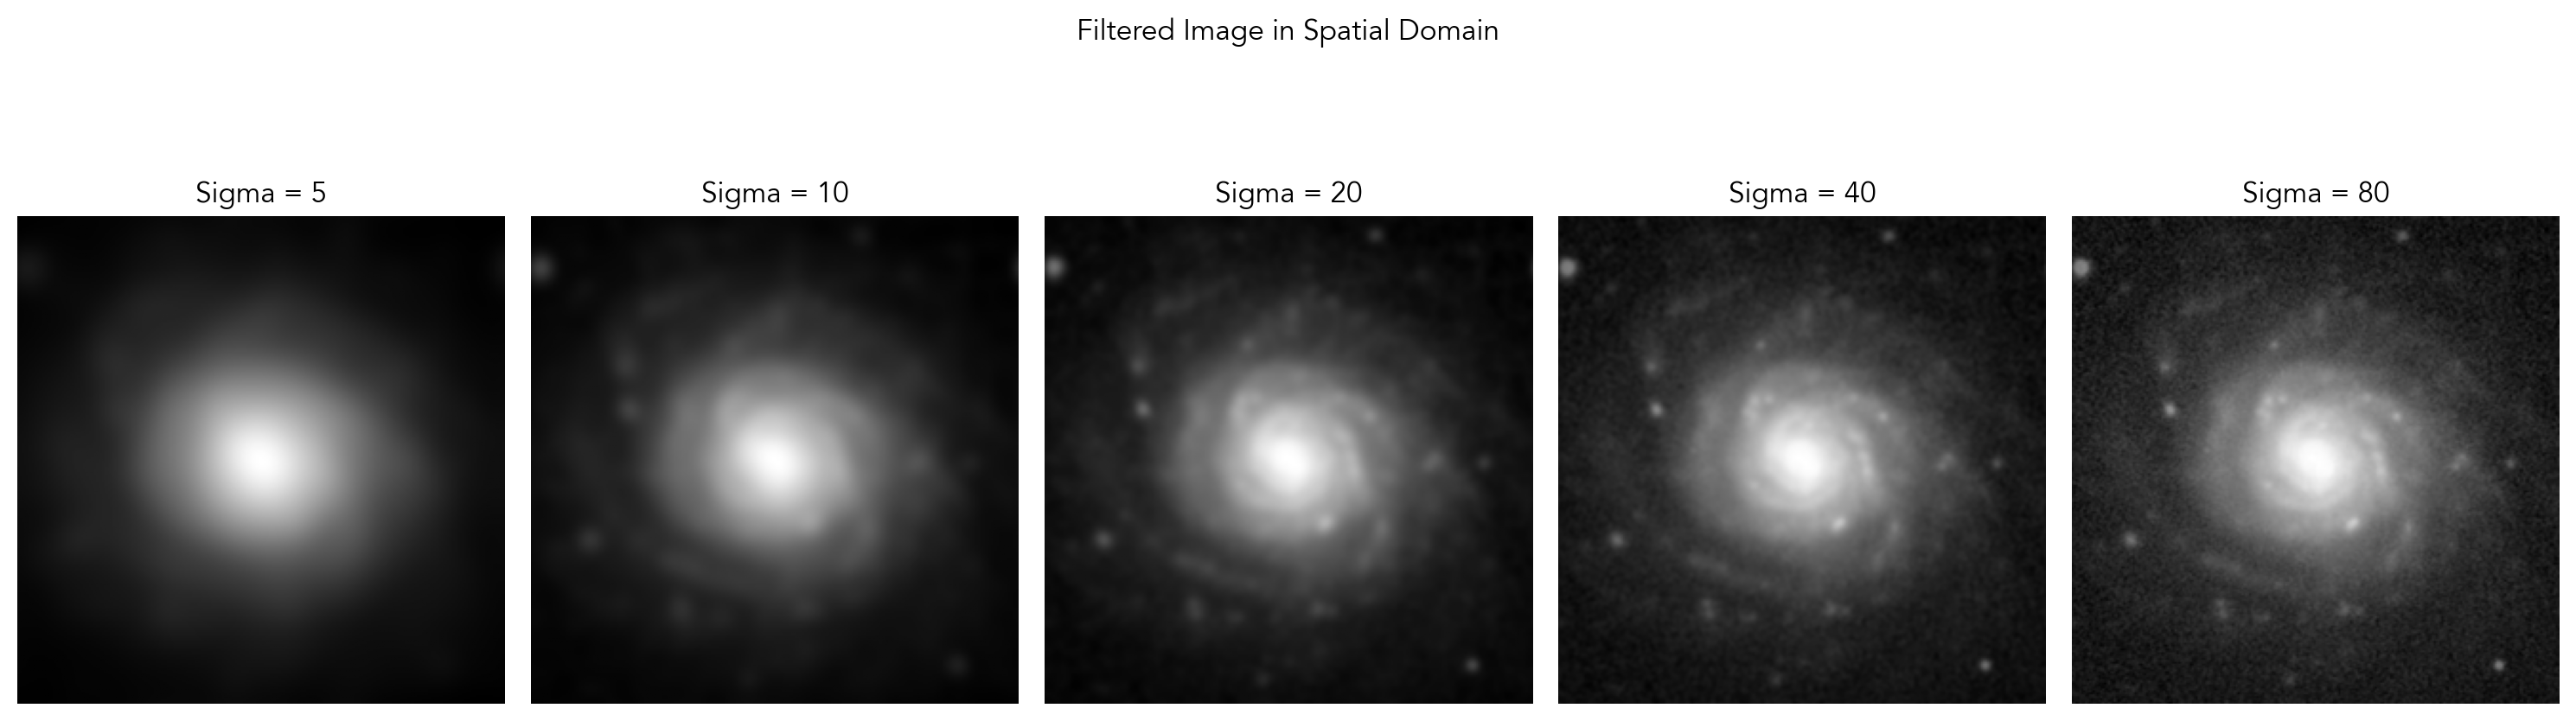

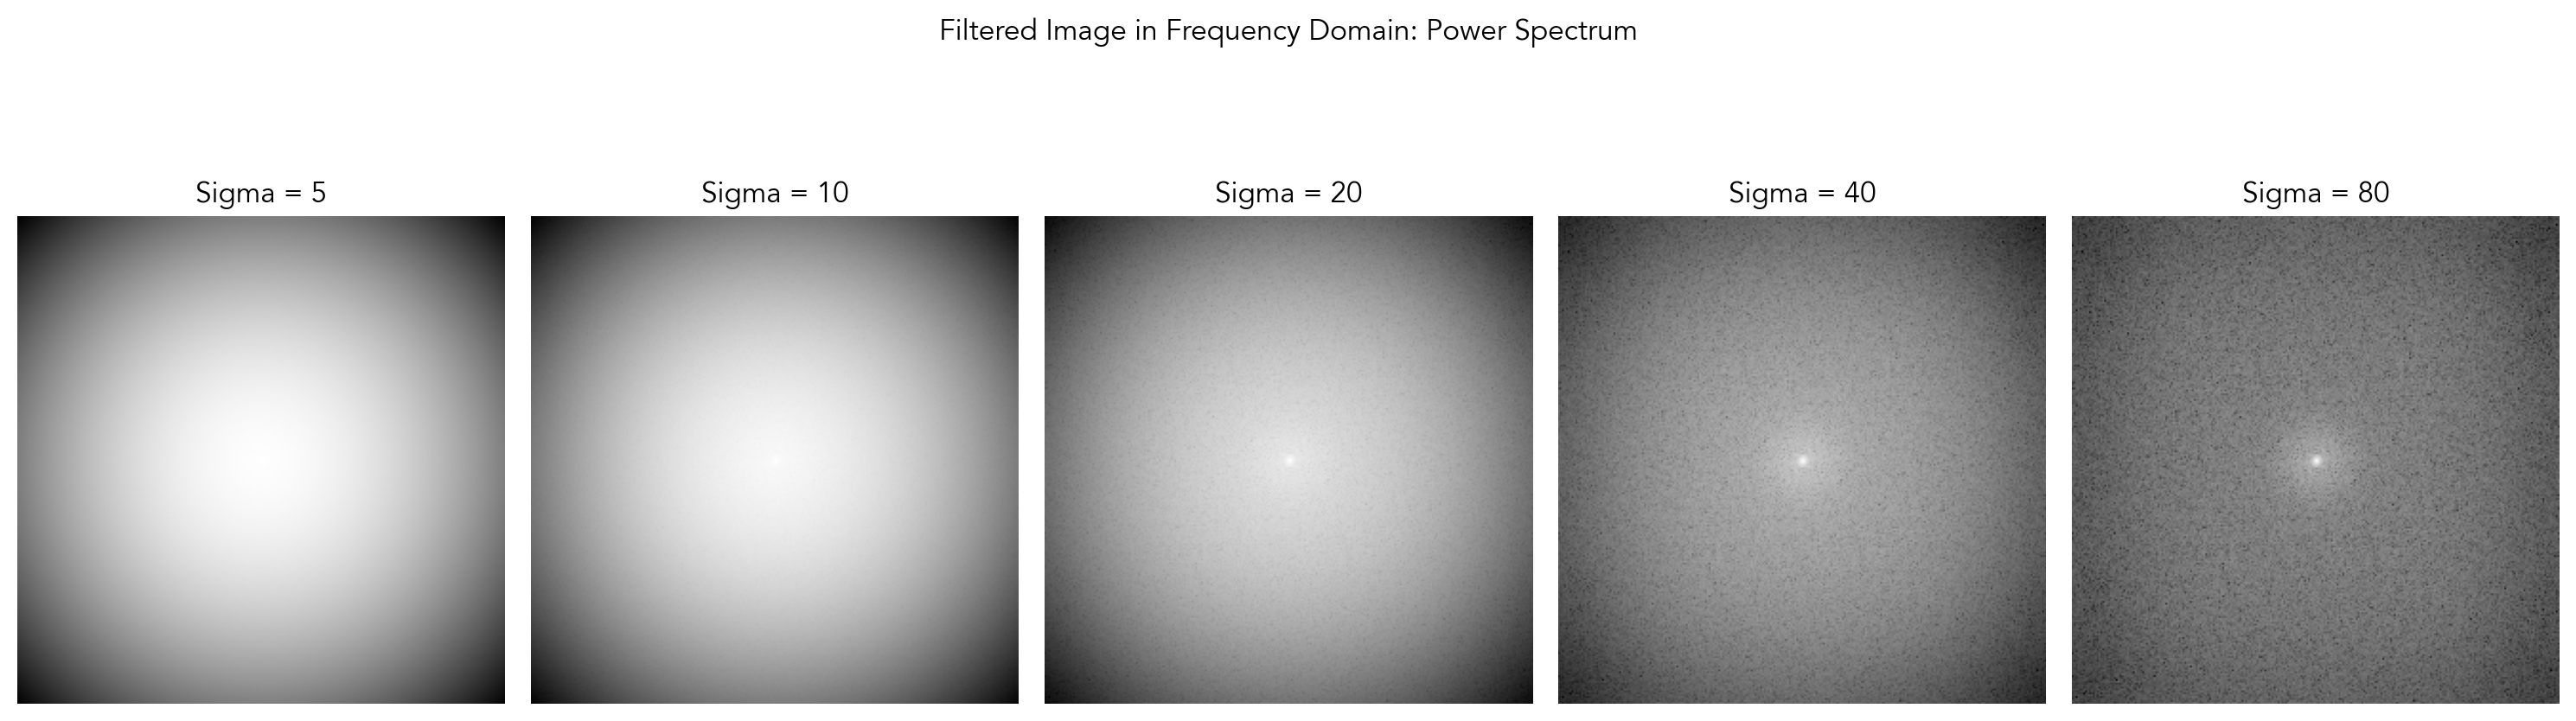

In [9]:
sigmas = [5, 10, 20, 40, 80]
fig, ax = plt.subplots(1, len(sigmas), figsize=(15, 5))
fig.suptitle("Filtered Image in Spatial Domain")
for i, sigma in enumerate(sigmas):
    gaussian_filter = gaussian_filter_freq(fgalaxy.shape, sigma)
    filtered_img = fgalaxy * gaussian_filter
    img_filtered = np.abs(np.fft.ifft2(filtered_img))

    ax[i].imshow(img_filtered, cmap='gray')
    ax[i].set_title(f"Sigma = {sigma}")
    ax[i].axis('off')
plt.show()

fig, ax = plt.subplots(1, len(sigmas), figsize=(15, 5))
fig.suptitle("Filtered Image in Frequency Domain: Power Spectrum")
for i, sigma in enumerate(sigmas):
    gaussian_filter = gaussian_filter_freq(fgalaxy.shape, sigma)
    filtered_img = fgalaxy * gaussian_filter
    ax[i].imshow(np.abs(np.fft.ifftshift(filtered_img)), cmap='gray', norm = 'log')
    ax[i].set_title(f"Sigma = {sigma}")
    ax[i].axis('off')

plt.show()

In [4]:
import pywt

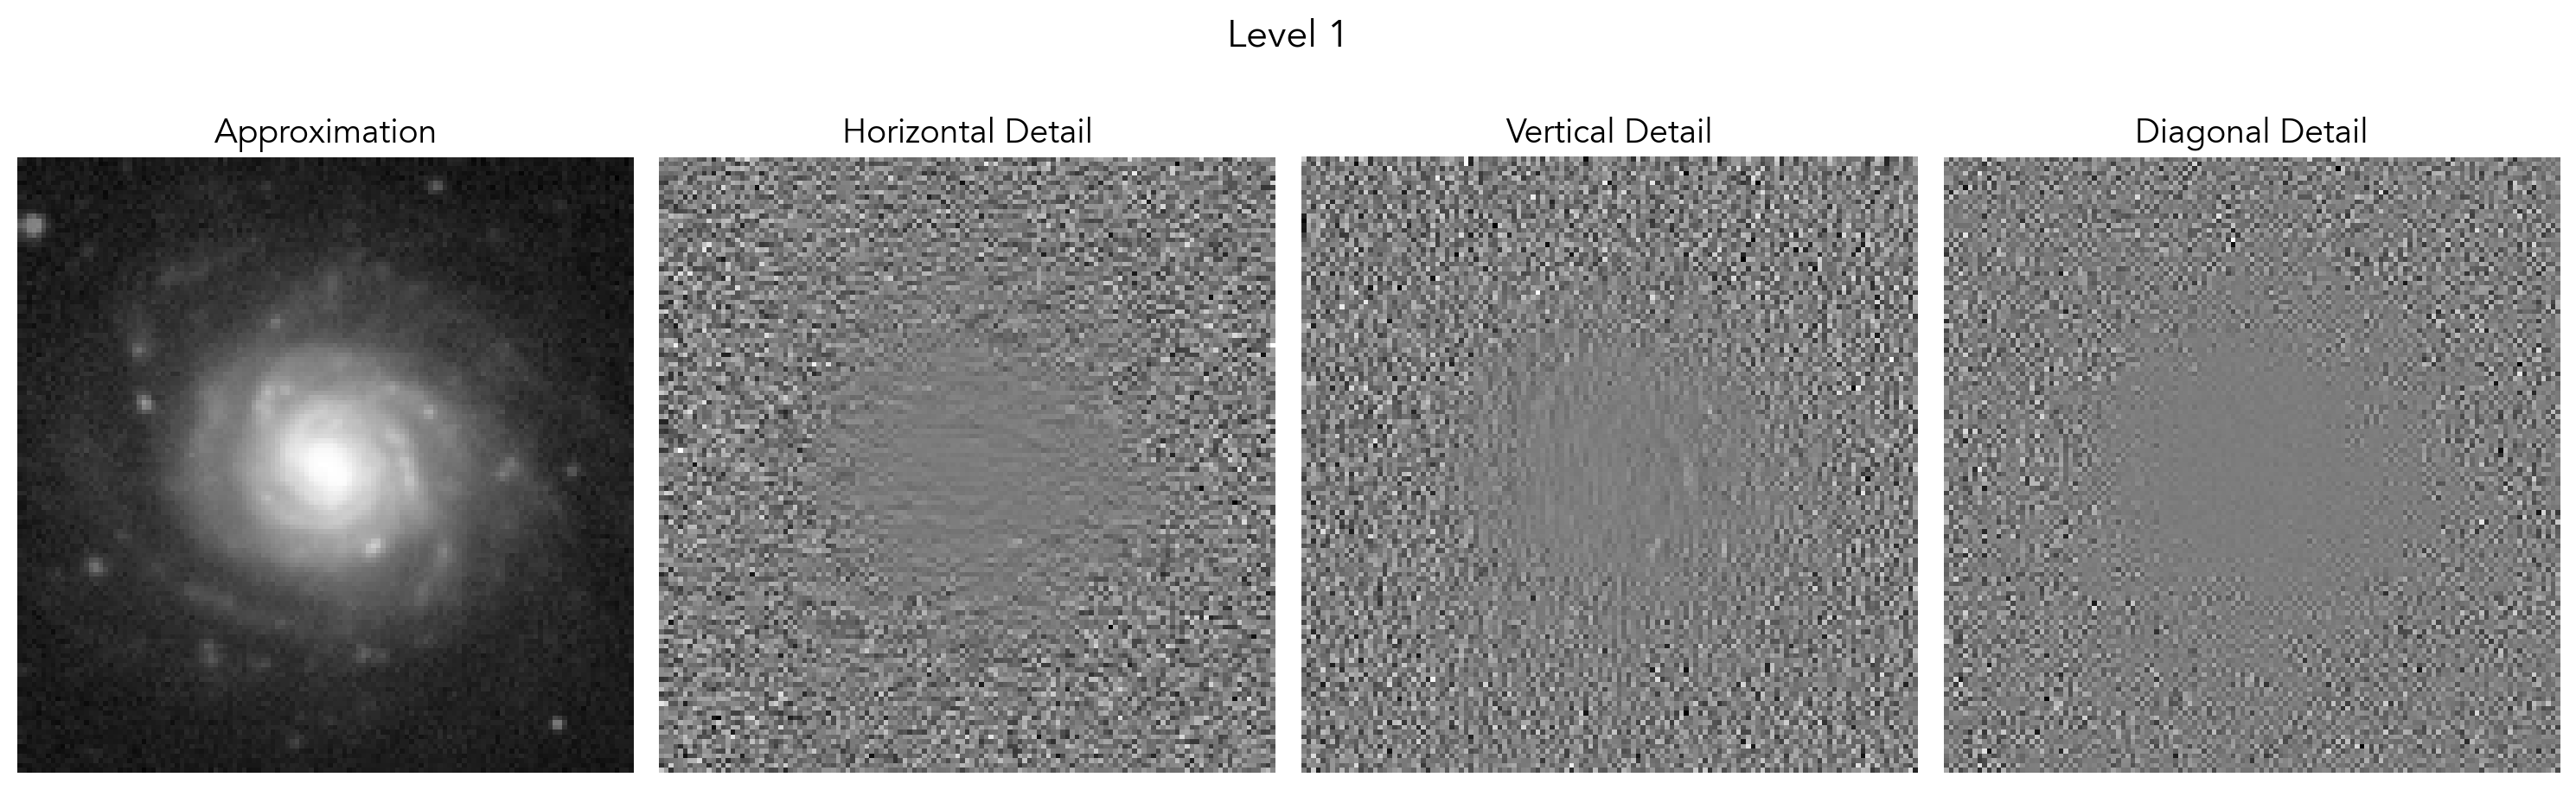

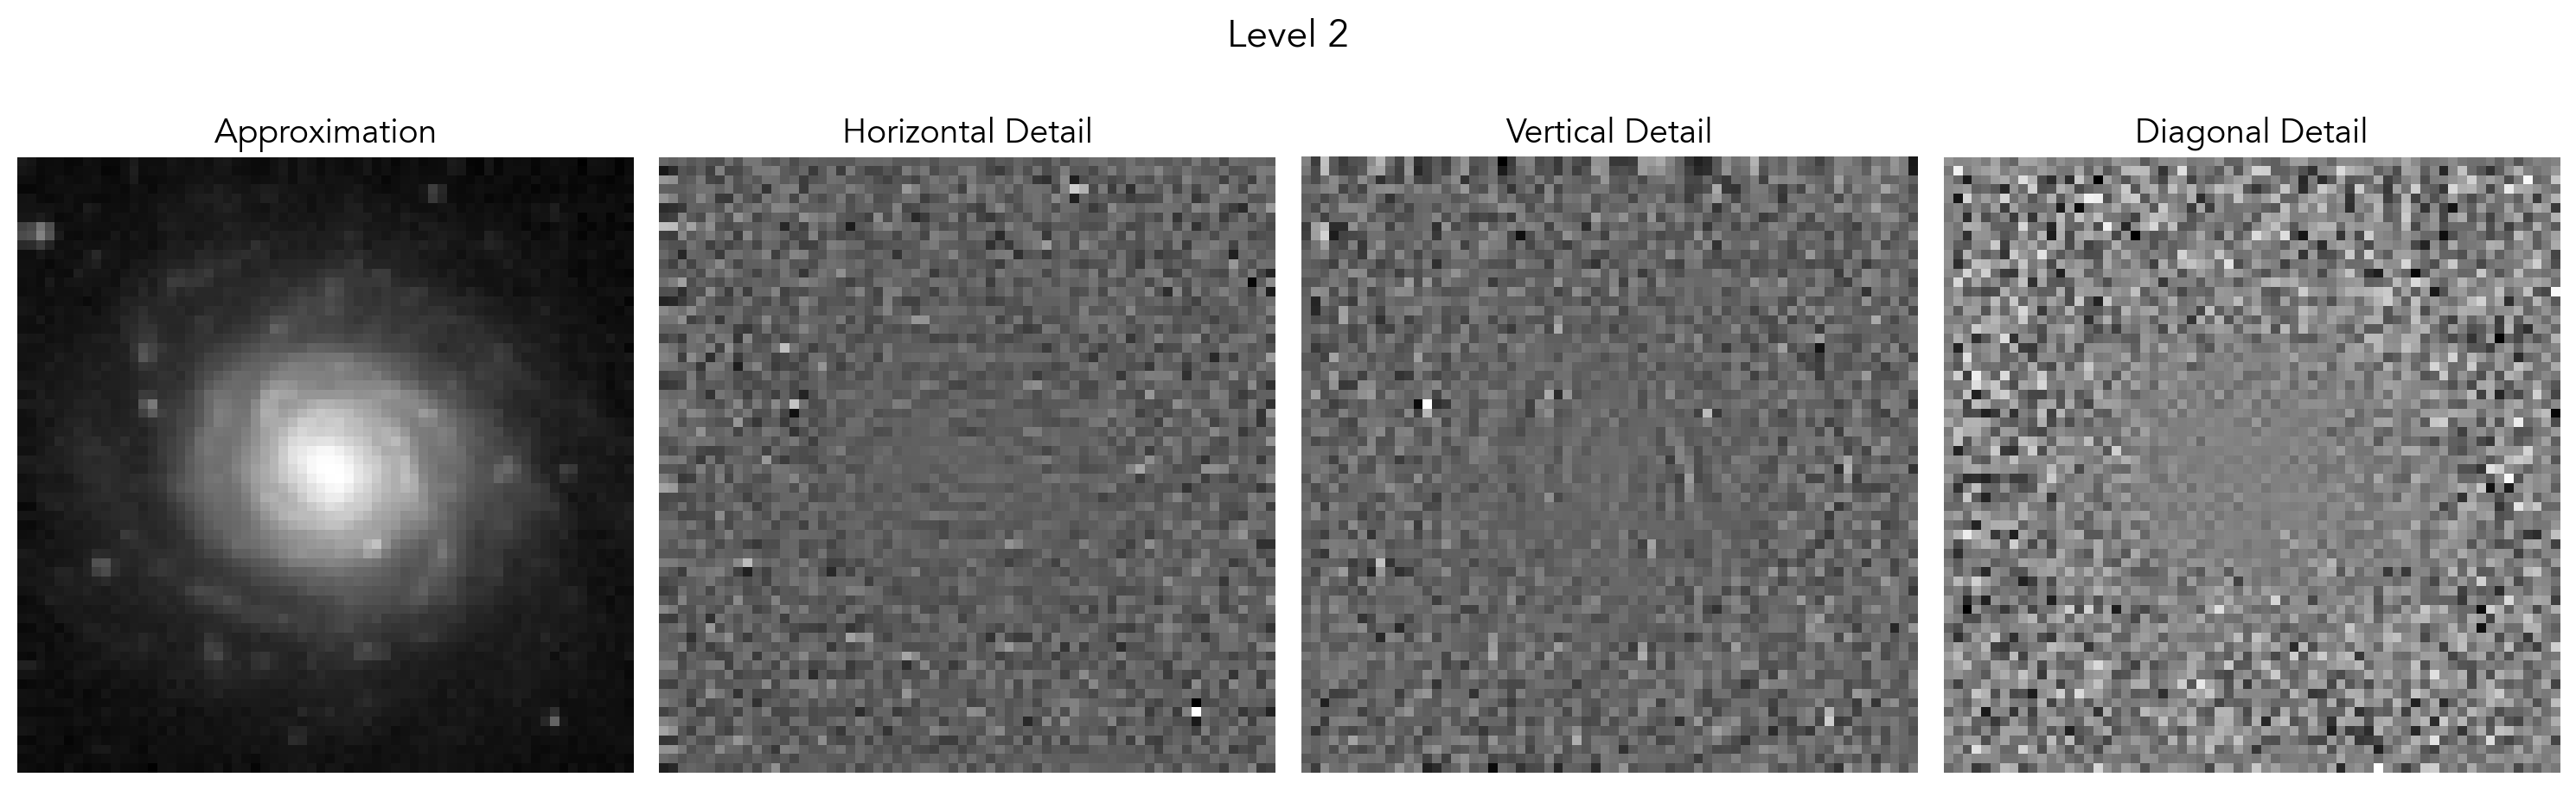

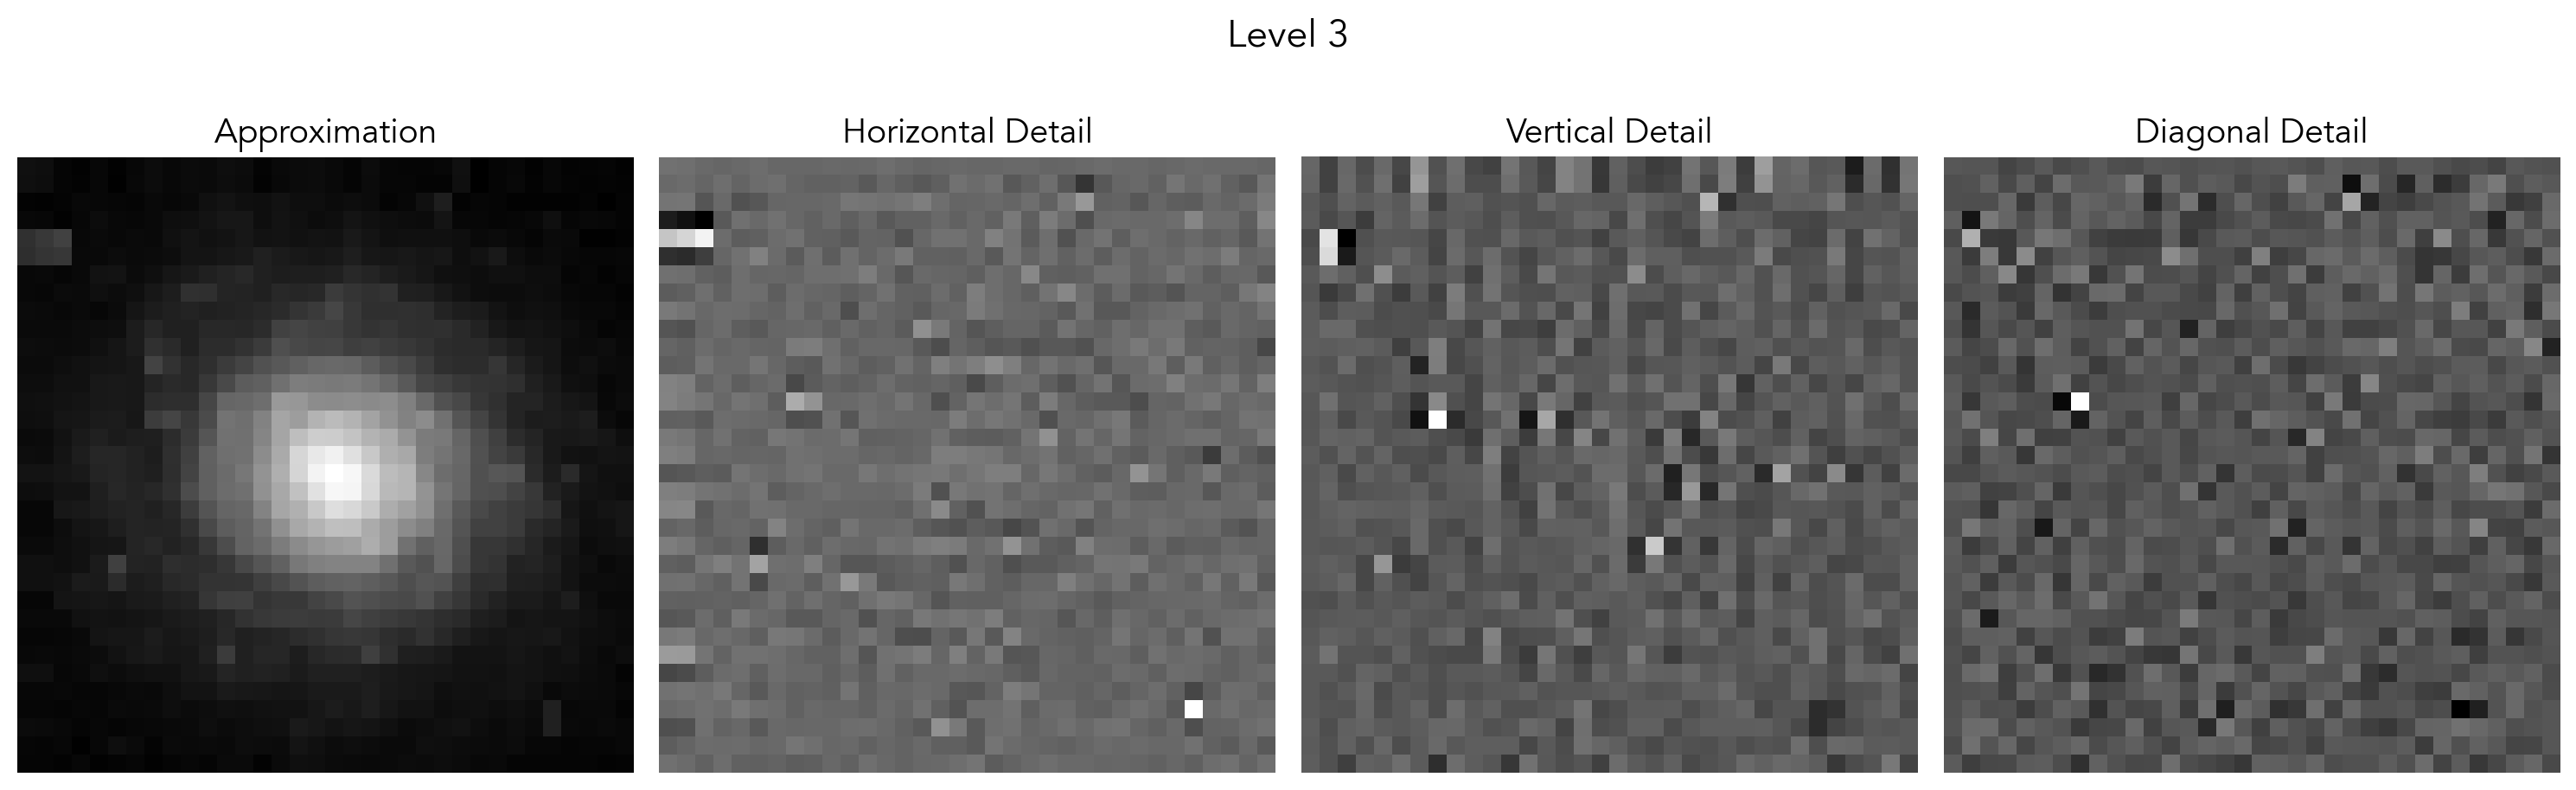

"
Hierarchical decomposition using DWT, At each level the image is split in average and detail components, The average component is further decomposed in the next level.



In [ ]:
# 1 level decomposition 1/4
cA1, (cH1, cV1, cD1) = pywt.dwt2(galaxy, wavelet="db2")

# 2 level decomposition 1/8
cA2, (cH2, cV2, cD2) = pywt.dwt2(cA1, wavelet="db2")

# 2 level decomposition 1/16
cA3, (cH3, cV3, cD3) = pywt.dwt2(cA2, wavelet="db2")

coeff = [(cA1, cH1, cV1, cD1), (cA2, cH2, cV2, cD2), (cA3, cH3, cV3, cD3)]


for i, (cA, cH, cV, cD) in enumerate(coeff):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    for j, (coeff, title) in enumerate(
        zip(
            [cA, cH, cV, cD],
            [
                "Approximation",
                "Horizontal Detail",
                "Vertical Detail",
                "Diagonal Detail",
            ],
        )
    ):
        axes[j].imshow(coeff, cmap="gray")
        axes[j].set_title(title, fontsize=14)
        axes[j].axis("off")

    plt.suptitle(f"Level {i+1}", fontsize=16)
    plt.show()

print("""
Hierarchical decomposition using DWT, At each level the image is split in average and detail components, The average component is further decomposed in the next level.
""")